# Project 1: Gradient-based Algorithms and Differentiable Programming
## By: Daniel Rivera | MAE 598: Design Optimization
## Prof. Max Yi Ren | Fall 2022


### The Optimization Problem
This optimization problem involves the following:
$$ d(t+1) = d(t) +v(t)\Delta t$$
$$ v(t+1) =v(t) + a(t)\Delta t$$ 
and
$$ a(t) = f_{\theta}(x(t)) $$

where d is the distance from the ground at any given time, v is the velocity at any given time, a is the acceleration at any given time and f is a neural network that has theta as a parameter. Our goal is to optimize this formulation of a rocket landing through the utilization of all of the aformentioned formulas. The optimization problem is as follows: 

$$ min_{\theta} \begin{Vmatrix} x(T) \end{Vmatrix}^2 $$
$$ d(t+1) = d(t) +v(t)\Delta t$$
$$ v(t+1) =v(t) + a(t)\Delta t$$ 
$$ a(t) = f_{\theta}(x(t)), \forall t=1,...,T-1 $$

### Applying Constraints

For this problem to be better understood, a list of constraints is needed to understand at which point we are attempting to mathematically represent and what each variable at the set point means physically for this application.

$$d(T)=0 $$ represents the rocket landing on the ground whereas $$v(T) =0 $$ the rocket lands with no velocity. In the case where $$ t(T)=0 $$ the rocket has landed upright and lastly $$ vt(T)=0 $$ mathematically represents a rocket that lands with zero rotation. 

### Considering Assumptions

Several assumptions must be made when optimizing a problem as complex as a rocket landing. Some of the essential assumptions include:

- The velocity of crosswinds and situational events such as weather patterns are ignored for this problem
- the y dimension is diregarded
- the true weight of the rocket, it's passengers, cargo etc, are not taken into account
- the amount of fuel that the rocket has is considered to be limitless
- lastly, we can assume that the thrusters produce a consistent and uniformly distrubuted amount of thrust to the entirety of the aircraft

### Implementing Drag into the code
We can make this rocket-landing problem more realistic by adding a variable called drag, which is an opposing force that an aircraft's wings experience in flight and especially when landing. This force is defined mathematically as:

$$ F_{D}=\frac{C_{D}\rho V^{2}A}{2} $$

Where we then simplify the Variable Drag even further as: 

$$ Drag= \frac{C_{D}V^{2}}{2} $$

Then our new optimization problem becomes:

$$ min_{\theta}(Drag,\Delta Drag, x(\theta))\begin{Vmatrix}x(T)\end{Vmatrix}^2 $$
$$ d(t+1) = d(t) +v(t)+Drag\Delta t$$
$$ v(t+1) =v(t) + a(t)+Drag\Delta t$$ 
$$ a(t) = f_{\theta}(x(t)), \forall t=1,...,T-1 $$
Let us just take a sample of 30 points of state:
$$ min_(\theta)1/30\sum\limits_{i=1}^{30}(x^(i)(T))^2 $$

Thus we've established an uncontrained problem with respect to theta.With that being said, we are able to make slight adjustments to the provided python script in order to determine solutions to this optimization problem. Several python libraries including pytortch and matplot lib are heavily utilized in order to simplify the coding. Furthermore, the matplot library is used in order to provide graphical representation of the solutions.Comments of each step within the code are provided along with a better problem formulation, and an analysis of findings at the end. 


In [24]:
# Import necessary libraries
import logging
import math
import random
import numpy as np
import time
import torch as t
import torch.nn as nn
from torch import optim
from torch.nn import utils
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)

In [25]:
# environment parameters including the time interval, 
#and various accelerations

# Environment parameters
FRAME_TIME = 0.1  # time interval
GRAVITY_ACCEL = 0.12  # gravity constant
VERT_BOOST_ACCEL = 0.18  # vertical thrust constant
THETA_BOOST_ACCEL = .14 # angular thrust constant
DRAG_ACCEL = 0.1 # drag constant

# Rocket Data
ROCKET_WIDTH = 1 # width of the rocket
ROCKET_HEIGHT = 4 # height of the rocket
RANDOMNESS = .000 # importance of the randomness
BATCH_SIZE = 5 # number of initial states being used to train the simulation

# Error Weights
y_weight = 1
y_dot_weight = 2
theta_weight = 1
theta_dot_weight = 2
GRAVITY_ACCEL = 0.12  # gravity constant
BOOST_ACCEL = 0.18  # thrust constant
DRAG_ACCEL = .06
# # the following parameters are not being used in the sample code
# PLATFORM_WIDTH = 0.25  # landing platform width
# PLATFORM_HEIGHT = 0.06  # landing platform height
# ROTATION_ACCEL = 20  # rotation constant

In [26]:
# define system dynamics
# Notes: 
# 0. You only need to modify the "forward" function
# 1. All variables in "forward" need to be PyTorch tensors.
# 2. All math operations in "forward" has to be differentiable, e.g., default PyTorch functions.
# 3. Do not use inplace operations, e.g., x += 1. Please see the following section for an example that does not work.
#This dynamics class contains init and forward functions. This is used to further mathematically represent the state
#and the corresponding action that occurs
class Dynamics(nn.Module):

    def __init__(self):
        super(Dynamics, self).__init__()

    @staticmethod
    def forward(state, action):

        """
        action1: vert thrust or no thrust
        action2: clockwise angular thrust or no thrust
        action3: counterclockwise angular thrust or not thrust
        state[0] = y
        state[1] = y_dot
        state[2] = theta
        state[3] = theta_dot
        """
    
        # Apply gravity
        delta_state_gravity = t.tensor([0., GRAVITY_ACCEL * FRAME_TIME, 0., 0.])

        # Apply vertical thrust
        delta_state_thrust = VERT_BOOST_ACCEL * FRAME_TIME * t.tensor([0., -1., 0., 0.]) * action[0]
        
        # Apply drag
        ROCKET_AREA = ROCKET_WIDTH*t.cos(t.tensor([0., 0., 1., 0.])*state)+ROCKET_HEIGHT*t.sin(t.tensor([0., 0., 1., 0.])*state)
        delta_state_drag = DRAG_ACCEL * FRAME_TIME * t.tensor([0., -1., 0., 0.]) * ROCKET_AREA * (t.tensor([0., -1., 0., 0.])*state) ** 2
        
        # Apply angular thrust
        c_delta_state_angle = THETA_BOOST_ACCEL * FRAME_TIME * t.tensor([0., 0., 0., -1.]) * action[1]
        cc_delta_state_angle = THETA_BOOST_ACCEL * FRAME_TIME * t.tensor([0., 0., 0., 1.]) * action[2]

        # Add randomn events
        Rand = t.rand(4)
        Rand[0] = 0
        Rand[2] = 0
        Polarity = t.rand(1)
        if(Polarity < .5):
            Rand = Rand * -1
        delta_state_rand = Rand * RANDOMNESS
            
        # Update velocity
        state = state + delta_state_thrust + delta_state_gravity + delta_state_drag + delta_state_rand + c_delta_state_angle + cc_delta_state_angle
        
        # Update state
        step_mat = t.tensor([[1., FRAME_TIME, 0., 0.],[0., 1., 0., 0.],[0., 0., 1., FRAME_TIME],[0., 0., 0., 1.]])
        state = t.matmul(step_mat, state)  
        return state


In [27]:
#The controller class also contains init and forward in order to establish a neural network
class Controller(nn.Module):

    def __init__(self, dim_input, dim_hidden, dim_output):
        """
        dim_input: # of system states
        dim_output: # of actions
        dim_hidden: up to you
        """
        
        # nn.Sigmoid()
        # nn.Tanh()
        # nn.ReLU()
        
        super(Controller, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(dim_input, dim_hidden),
            nn.ReLU(), nn.Sigmoid(),
            nn.Linear(dim_hidden, dim_output),
            nn.Tanh()
        )
        

    def forward(self, state):
        action = self.network(state)
        return action


In [28]:
# a deterministic controller
# Note:
# 0. You only need to change the network architecture in "__init__"
# 1. nn.Sigmoid outputs values from 0 to 1, nn.Tanh from -1 to 1
# 2. You have all the freedom to make the network wider (by increasing "dim_hidden") or deeper (by adding more lines to nn.Sequential)
# 3. Always start with something simple
#t.transpose(xthrust_t.unsqueeze(0),0,1)

class Simulation(nn.Module):
# runs through the steps (T)
    def __init__(self, controller, dynamics, T, i):
        super(Simulation, self).__init__()
        self.state = self.initialize_state(i)
        self.controller = controller
        self.dynamics = dynamics
        self.T = T
        self.action_trajectory = []
        self.state_trajectory = []

    def forward(self, state):
        self.action_trajectory = []
        self.state_trajectory = []
        for _ in range(T):
            action = self.controller.forward(state)
            state = self.dynamics.forward(state, action)
            self.action_trajectory.append(action)
            self.state_trajectory.append(state)
        return self.error(state)

    @staticmethod
    def initialize_state(i):
    #The batch is a group of initial states being tested. This was taken from a paper and multiplied by a factor
    #to truly test the simulator

        batch = [[2.6, 0., -11.2, 2.],[8.4, -1, -6.4, 0.],[1.05, 0., 3.05, -0.9],[3.125, -0.375, -1.35, 0.5],[1.25, 0.55, 2.8, 1.4]]
        state = batch[i]
        print("Initial state= ", state)
        return t.tensor(state, requires_grad=False).float()

    def error(self, state):
        obj = y_weight*state[0]**2 + y_dot_weight*state[1]**2 + theta_weight*state[2]**2 + theta_dot_weight*state[3]**2 
        return obj
    

In [29]:
# the simulator that rolls out x(1), x(2), ..., x(T)
# Note:
# 0. Need to change "initialize_state" to optimize the controller over a distribution of initial states
# 1. self.action_trajectory and self.state_trajectory stores the action and state trajectories along time
#The optimize class applies error and gradient terms in order to better mathematically represent the rocket landing
class Optimize:
# calculates the gradient and the loss to optimize the neural network
    def __init__(self, simulation):
        self.simulation = simulation
        self.parameters = simulation.controller.parameters()
        self.optimizer = optim.LBFGS(self.parameters, lr=0.01)

    def step(self):
        def closure():
            loss = self.simulation(self.simulation.state)
            self.optimizer.zero_grad()
            loss.backward()
            return loss
        self.optimizer.step(closure)
        return closure()
    
    def train(self, epochs):
        for epoch in range(epochs):
            loss = self.step()
            print('[%d] loss: %.3f' % (epoch + 1, loss))
            if((epoch+1) == epochs):
                self.visualize()
#Visualize formats each iteration into a cohesive and easy to read plot 
    def visualize(self):
        data = np.array([self.simulation.state_trajectory[i].detach().numpy() for i in range(self.simulation.T)])
        # Plots the position of the rocket with respect to velocity over time
        y = data[:, 0]
        y_dot = data[:, 1]
        theta = data[:, 2]
        theta_dot = data[:, 3]
                
        # Plots the data as a subplot
        fig = plt.figure()
        
        # plots the position vs the velocity of the rocket
        plt.subplot(1,2,1)
        plt.xlabel("Height of Rocket")
        plt.ylabel("Velocity of Rocket")
        plt.plot(y, y_dot)
        
        # plots the angle of the rocket and its rotational velocity
        plt.subplot(1,2,2)
        plt.plot(theta,theta_dot)
        plt.xlabel("Angle of Rocket")
        plt.ylabel("Angle Velocity of Rocket")
        plt.show()  

Initial state=  [2.6, 0.0, -11.2, 2.0]
System has been initialized
[1] loss: 47.932
[2] loss: 29.445
[3] loss: 20.098
[4] loss: 14.008
[5] loss: 9.897
[6] loss: 7.127
[7] loss: 5.260
[8] loss: 3.956
[9] loss: 3.016
[10] loss: 2.335
[11] loss: 1.847
[12] loss: 1.503
[13] loss: 1.258
[14] loss: 1.082
[15] loss: 0.951
[16] loss: 0.852
[17] loss: 0.780
[18] loss: 0.730
[19] loss: 0.698
[20] loss: 0.678
[21] loss: 0.665
[22] loss: 0.654
[23] loss: 0.626
[24] loss: 0.514
[25] loss: 0.316
[26] loss: 0.158
[27] loss: 0.106
[28] loss: 0.076
[29] loss: 0.055
[30] loss: 0.041
[31] loss: 0.028
[32] loss: 0.021
[33] loss: 0.015
[34] loss: 0.011
[35] loss: 0.009
[36] loss: 0.007
[37] loss: 0.005
[38] loss: 0.004
[39] loss: 0.003
[40] loss: 0.003


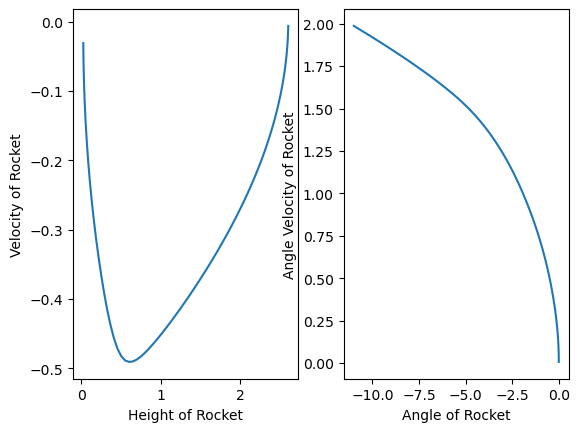

Training for this initial state is complete
Initial state=  [8.4, -1, -6.4, 0.0]
System has been initialized
[1] loss: 376.706
[2] loss: 276.074
[3] loss: 16.351
[4] loss: 7.953
[5] loss: 4.327
[6] loss: 5.664
[7] loss: 4.462
[8] loss: 3.679
[9] loss: 3.185
[10] loss: 2.875
[11] loss: 2.678
[12] loss: 2.550
[13] loss: 2.462
[14] loss: 2.404
[15] loss: 2.360
[16] loss: 2.325
[17] loss: 2.294
[18] loss: 2.257
[19] loss: 1.950
[20] loss: 1.727
[21] loss: 1.495
[22] loss: 1.219
[23] loss: 0.983
[24] loss: 0.801
[25] loss: 0.661
[26] loss: 0.547
[27] loss: 0.453
[28] loss: 0.370
[29] loss: 0.297
[30] loss: 0.236
[31] loss: 0.185
[32] loss: 0.143
[33] loss: 0.110
[34] loss: 0.085
[35] loss: 0.059
[36] loss: 0.044
[37] loss: 0.033
[38] loss: 0.025
[39] loss: 0.019
[40] loss: 0.014


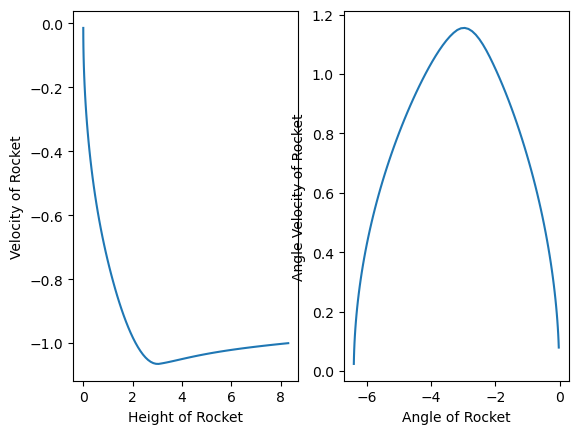

Training for this initial state is complete
Initial state=  [1.05, 0.0, 3.05, -0.9]
System has been initialized
[1] loss: 99.889
[2] loss: 65.886
[3] loss: 41.431
[4] loss: 25.394
[5] loss: 16.011
[6] loss: 9.321
[7] loss: 5.329
[8] loss: 3.743
[9] loss: 2.116
[10] loss: 1.155
[11] loss: 0.933
[12] loss: 0.815
[13] loss: 0.776
[14] loss: 0.739
[15] loss: 0.701
[16] loss: 0.649
[17] loss: 0.571
[18] loss: 0.470
[19] loss: 0.409
[20] loss: 0.267
[21] loss: 0.243
[22] loss: 0.233
[23] loss: 0.164
[24] loss: 0.090
[25] loss: 0.057
[26] loss: 0.037
[27] loss: 0.025
[28] loss: 0.017
[29] loss: 0.010
[30] loss: 0.007
[31] loss: 0.005
[32] loss: 0.003
[33] loss: 0.002
[34] loss: 0.001
[35] loss: 0.001
[36] loss: 0.001
[37] loss: 0.000
[38] loss: 0.000
[39] loss: 0.000
[40] loss: 0.000


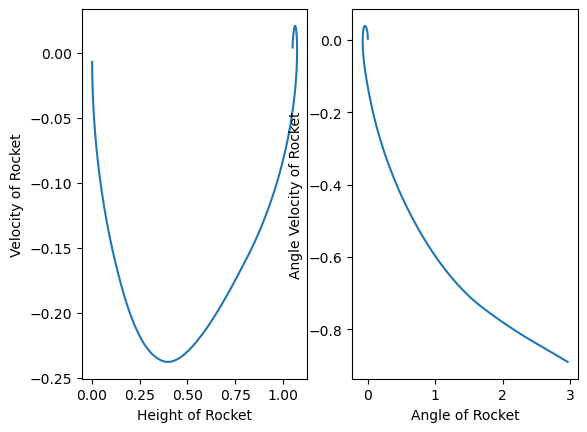

Training for this initial state is complete
Initial state=  [3.125, -0.375, -1.35, 0.5]
System has been initialized
[1] loss: 17.986
[2] loss: 8.565
[3] loss: 5.078
[4] loss: 2.482
[5] loss: 1.816
[6] loss: 1.415
[7] loss: 1.180
[8] loss: 1.029
[9] loss: 0.923
[10] loss: 0.844
[11] loss: 0.788
[12] loss: 0.748
[13] loss: 0.719
[14] loss: 0.692
[15] loss: 0.664
[16] loss: 0.629
[17] loss: 0.589
[18] loss: 0.505
[19] loss: 0.276
[20] loss: 0.253
[21] loss: 0.233
[22] loss: 0.201
[23] loss: 0.171
[24] loss: 0.124
[25] loss: 0.085
[26] loss: 0.058
[27] loss: 0.036
[28] loss: 0.022
[29] loss: 0.014
[30] loss: 0.009
[31] loss: 0.006
[32] loss: 0.004
[33] loss: 0.002
[34] loss: 0.001
[35] loss: 0.001
[36] loss: 0.001
[37] loss: 0.000
[38] loss: 0.000
[39] loss: 0.000
[40] loss: 0.000


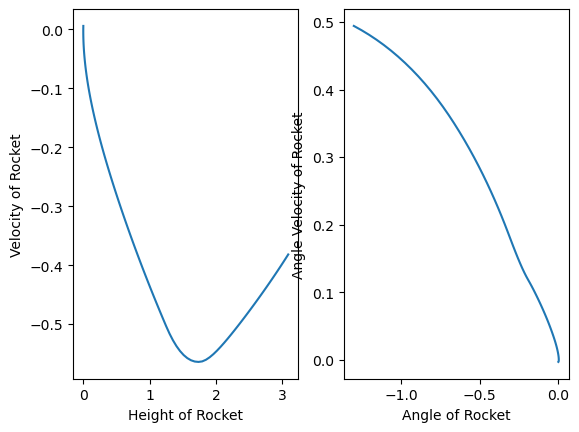

Training for this initial state is complete
Initial state=  [1.25, 0.55, 2.8, 1.4]
System has been initialized
[1] loss: 183.551
[2] loss: 80.716
[3] loss: 67.625
[4] loss: 59.528
[5] loss: 53.682
[6] loss: 48.367
[7] loss: 43.703
[8] loss: 39.904
[9] loss: 36.700
[10] loss: 33.943
[11] loss: 31.369
[12] loss: 27.019
[13] loss: 25.131
[14] loss: 24.573
[15] loss: 24.100
[16] loss: 23.711
[17] loss: 23.395
[18] loss: 23.142
[19] loss: 22.941
[20] loss: 22.778
[21] loss: 22.648
[22] loss: 22.542
[23] loss: 22.459
[24] loss: 22.392
[25] loss: 22.339
[26] loss: 22.295
[27] loss: 22.231
[28] loss: 21.777
[29] loss: 21.676
[30] loss: 21.444
[31] loss: 21.354
[32] loss: 21.289
[33] loss: 21.249
[34] loss: 21.221
[35] loss: 21.199
[36] loss: 21.182
[37] loss: 21.169
[38] loss: 21.159
[39] loss: 21.150
[40] loss: 21.143


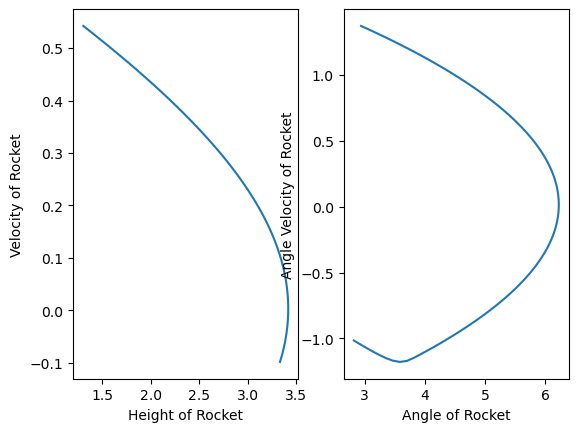

Training for this initial state is complete


In [30]:
# Now it's time to run the code!

T = 100  # number of time steps
dim_input = 4  # state space dimensions
dim_hidden = 12  # latent dimensions
dim_output = 3  # action space dimensions
d = Dynamics()  # define dynamics
c = Controller(dim_input, dim_hidden, dim_output)  # define controller

# Implements the neural network over the aformentioned batch of initial states
for i in range(BATCH_SIZE):
    s = Simulation(c, d, T, i)  # define simulation
    o = Optimize(s)  # define optimizer
    print("System has been initialized")
    o.train(40)  # solve the optimization problem within 60 iterations of this for loop
    print("Training for this initial state is complete")

### Analysis and Discussion of Results

The initial states that were tested include:

$$ initial state=[[2.6, 0., -11.2, 2.],[8.4, -1, -6.4, 0.],[1.05, 0., 3.05, -0.9],[3.125, -0.375, -1.35, 0.5],[1.25, 0.55, 2.8, 1.4]] $$

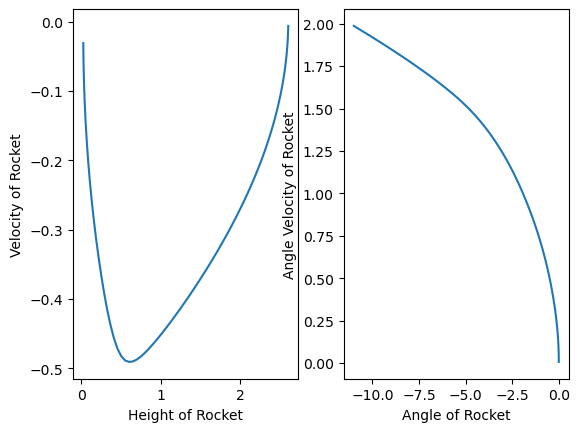
As shown above for state1=[2.6, 0., -11.2, 2.], the loss converges nearly to zero by the 34th iteration. The velocity of the rocket seems parabolic with respect to its height. When it comes to the Angular velocity with respect to the angle of the rocket, this seems to decay exponentially.

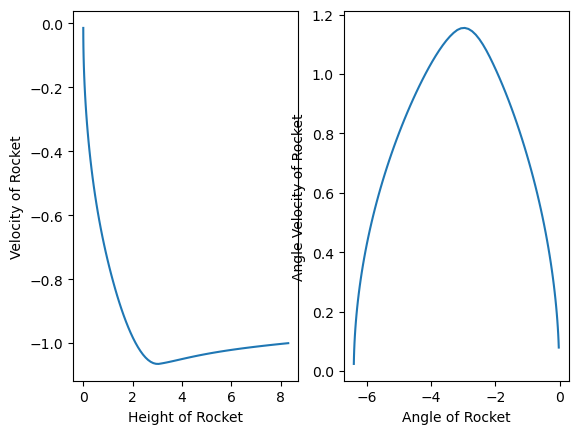
At state2=[8.4, -1, -6.4, 0.], the loss converges close to zero at the 37th iteration. The velocity of the rocket decreases rapidly from the height of 0 to 2, then seems to almost approach an asymptote as the height exceeds 2.5.The Angular velocity of the rocket takes on the shape of a concave parabola. 

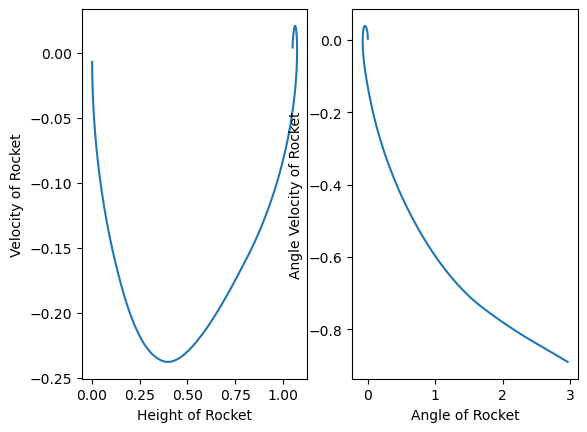!
For state3=[1.05, 0., 3.05, -0.9] the erorr converges to zero on the 37th iteration. Again the velocity of the rocket takes a parabolic shape with respect to the rocket's height. The Angular velocity however, seems to exponentially decay as the angle of the rocket increases. 

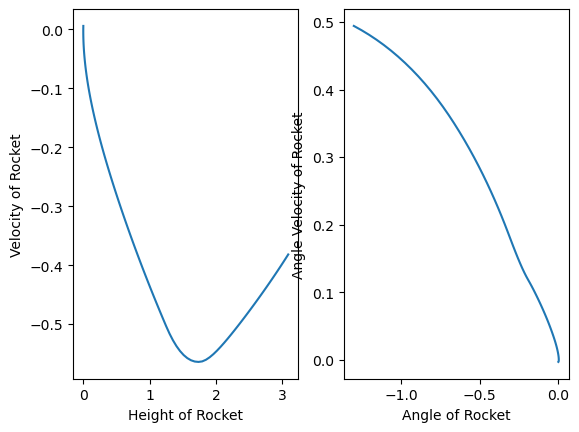
state4=[3.125, -0.375, -1.35, 0.5] converges to zero at the 37th iteration. The velocity of the rocket from this initial state is close to parabolic with respect to the height of the rocket. The angular velocity of the rocket is almost linear to the rocket's angle. 

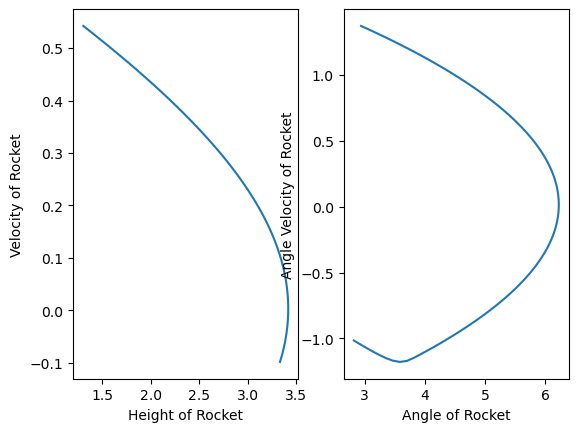
state5=[1.25, 0.55, 2.8, 1.4] unfortunately did not converge to a solution. Although the amount of error is decreasing after each successive iteration, the loop requires more iterations for this initial state to be solved. A better way to conduct this so that every state converges is to optimize five separate for loops so that each respective state can be given the opmtimal number of iterations for that particular scenario to converge. 
